In [ ]:
import pandas as pd

In [ ]:
actuator_df = pd.read_csv("data_new.txt")

actuator_df["timestamp_utc"] = pd.to_datetime(
    actuator_df["timestamp_utc"], format="%H:%M:%S.%f"
)

# Extract the date part from timestamp_utc and compare with the date to remove
date_to_remove = pd.to_datetime("2025-04-11").date()
actuator_df = actuator_df[actuator_df["timestamp_utc"].dt.date != date_to_remove]

# Convert timestamp_utc to time only, removing the date part and keeping only the time column and in 12h format (-8h)
actuator_df["timestamp_utc"] = actuator_df["timestamp_utc"] - pd.Timedelta(hours=12)


# save to new csv file, with csv extension
actuator_df.to_csv("data_cleaned.csv", index=False, date_format="%H:%M:%S.%f")

In [ ]:
# Step 1: Read without parsing yet
marker_df = pd.read_csv("marker_1_.txt", sep="\t")

# Step 2: Convert Frame column to datetime with a dummy date
marker_df["Frame"] = pd.to_datetime(marker_df["Frame"], format="%H:%M:%S.%f")

# Now Frame column is of dtype datetime64[ns] and keeps milliseconds
print(marker_df.dtypes)
print(marker_df["Frame"].head())
#print number of rows in marker_df
print("Number of rows in marker_df before cleaning:", len(marker_df))
# for x y and z, eliminate the rows if the value is over 100 different from both the previous and the next value
# show the first cleaned rows of the dataframe as a sample

marker_df = marker_df[
    (marker_df["X"].diff().abs() <= 100) & (marker_df["X"].diff(-1).abs() <= 100)
]
marker_df = marker_df[
    (marker_df["Y"].diff().abs() <= 100) & (marker_df["Y"].diff(-1).abs() <= 100)
]
marker_df = marker_df[
    (marker_df["Z"].diff().abs() <= 100) & (marker_df["Z"].diff(-1).abs() <= 100)
]
print("Number of rows in marker_df after cleaning:", len(marker_df))

# Z axis is calibrated to add 135.9
marker_df["Z"] = marker_df["Z"] + 135.9

# save to new csv file, with csv extension
marker_df.to_csv("marker_cleaned.csv", index=False, date_format="%H:%M:%S.%f")


In [ ]:
cleaned_marker_df = pd.read_csv("marker_cleaned.csv")

cleaned_marker_df["Frame"] = pd.to_datetime(
    cleaned_marker_df["Frame"], format="%H:%M:%S.%f"
)

cleaned_data_df = pd.read_csv("data_cleaned.csv")

cleaned_data_df["timestamp_utc"] = pd.to_datetime(
    cleaned_data_df["timestamp_utc"], format="%H:%M:%S.%f"
)


# Merge the two dataframes on the timestamp_utc and Frame columns with tolerance of 10ms
merged_df = pd.merge_asof(
    cleaned_marker_df,
    cleaned_data_df,
    left_on="Frame",
    right_on="timestamp_utc",
    tolerance=pd.Timedelta("5ms"),
    direction="nearest",
)

# === Remove those with NaN marker data ===
merged_df = merged_df.dropna(subset=["X", "Y", "Z"])


# === Remove those with NaN actuator data ===
merged_df = merged_df.dropna(subset=["roll"])

merged_df = merged_df.drop(
    columns=["timestamp_utc"]
)

print("Number of rows in merged_df:", len(merged_df))

# save to new csv file, with csv extension
merged_df.to_csv("merged_cleaned.csv", index=False, date_format="%H:%M:%S.%f")





# Start Training

We finished processing the data. First step is to try training the NN solely on data without PCC model.

Using device: cuda
Epoch 0: Loss = 1.032650
Epoch 10: Loss = 0.706813
Epoch 20: Loss = 0.440853
Epoch 30: Loss = 0.220175
Epoch 40: Loss = 0.088613
Epoch 50: Loss = 0.058373
Epoch 60: Loss = 0.055983
Epoch 70: Loss = 0.049419
Epoch 80: Loss = 0.048346
Epoch 90: Loss = 0.047559
Epoch 100: Loss = 0.046848
Epoch 110: Loss = 0.046441
Epoch 120: Loss = 0.046051
Epoch 130: Loss = 0.045742
Epoch 140: Loss = 0.045483
Epoch 150: Loss = 0.045252
Epoch 160: Loss = 0.045034
Epoch 170: Loss = 0.044835
Epoch 180: Loss = 0.044662
Epoch 190: Loss = 0.044505
Validation Set Error (100 Unseen Test Samples):
X  |  MAE: 0.6616  |  RMSE: 0.8355
Y  |  MAE: 0.7697  |  RMSE: 0.9987
Z  |  MAE: 0.9069  |  RMSE: 1.2201


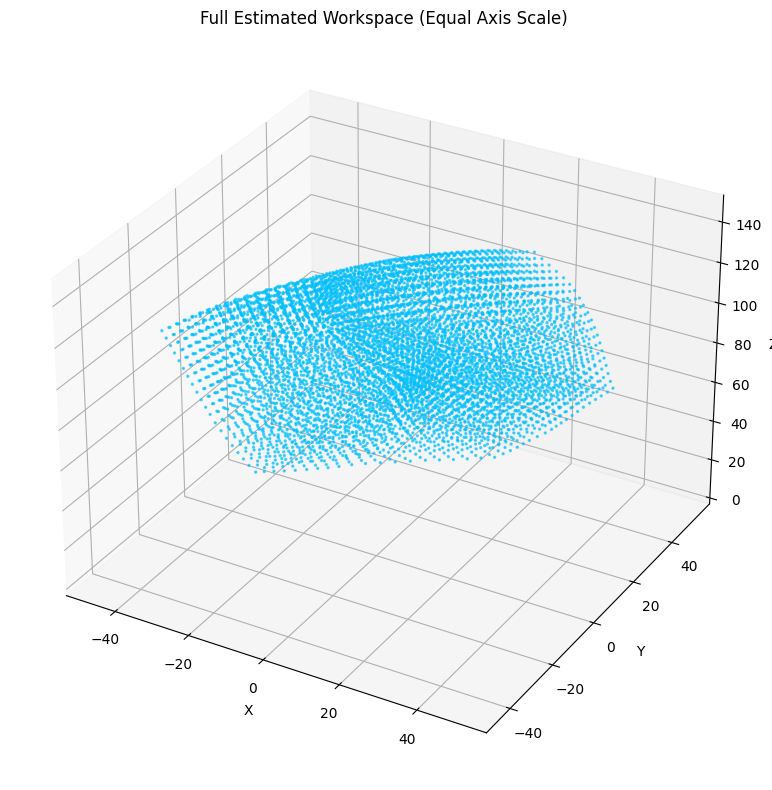

(ActuatorToXYZ(
   (net): Sequential(
     (0): Linear(in_features=3, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): ReLU()
     (4): Linear(in_features=64, out_features=3, bias=True)
   )
 ),
 StandardScaler(),
 StandardScaler())

In [1]:
import util

util.train_and_visualize_workspace("merged_cleaned.csv")

# Residual Learning

Now we try to combine the PCC model and the data

In [1]:
import util

model, scaler_x, scaler_y, pcc_model = util.train_with_residual_model("merged_cleaned.csv")





Using device: cuda
Epoch 0: Train Loss = 1.506954 | Val Loss = 0.884352
Epoch 5: Train Loss = 1.311115 | Val Loss = 0.852627
Epoch 10: Train Loss = 1.149256 | Val Loss = 0.806782
Epoch 15: Train Loss = 1.021360 | Val Loss = 0.747093
Epoch 20: Train Loss = 0.929267 | Val Loss = 0.676381
Epoch 25: Train Loss = 0.860163 | Val Loss = 0.611212
Epoch 30: Train Loss = 0.815761 | Val Loss = 0.563362
Epoch 35: Train Loss = 0.780446 | Val Loss = 0.536630
Epoch 40: Train Loss = 0.759593 | Val Loss = 0.525836
Epoch 45: Train Loss = 0.742360 | Val Loss = 0.521969
Epoch 50: Train Loss = 0.732421 | Val Loss = 0.519973
Epoch 55: Train Loss = 0.721316 | Val Loss = 0.517126
Epoch 60: Train Loss = 0.715217 | Val Loss = 0.513609
Epoch 65: Train Loss = 0.704764 | Val Loss = 0.510359
Epoch 70: Train Loss = 0.701153 | Val Loss = 0.507957
Epoch 75: Train Loss = 0.694258 | Val Loss = 0.506068
Epoch 80: Train Loss = 0.690086 | Val Loss = 0.504465
Epoch 85: Train Loss = 0.687151 | Val Loss = 0.503201
Epoch 90: T

# Export to TorchScript

TorchScript is c++, which Rust can use

Using device: cuda
Epoch 0: Loss = 0.916386
Epoch 10: Loss = 0.624653
Epoch 20: Loss = 0.374313
Epoch 30: Loss = 0.174252
Epoch 40: Loss = 0.070994
Epoch 50: Loss = 0.057781
Epoch 60: Loss = 0.052117
Epoch 70: Loss = 0.048080
Epoch 80: Loss = 0.047615
Epoch 90: Loss = 0.046584
Epoch 100: Loss = 0.046059
Epoch 110: Loss = 0.045607
Epoch 120: Loss = 0.045247
Epoch 130: Loss = 0.044932
Epoch 140: Loss = 0.044671
Epoch 150: Loss = 0.044435
Epoch 160: Loss = 0.044222
Epoch 170: Loss = 0.044030
Epoch 180: Loss = 0.043857
Epoch 190: Loss = 0.043705
Validation Set Error (100 Unseen Test Samples):
X  |  MAE: 0.8267  |  RMSE: 0.9970
Y  |  MAE: 0.7961  |  RMSE: 1.0042
Z  |  MAE: 0.6231  |  RMSE: 0.8543


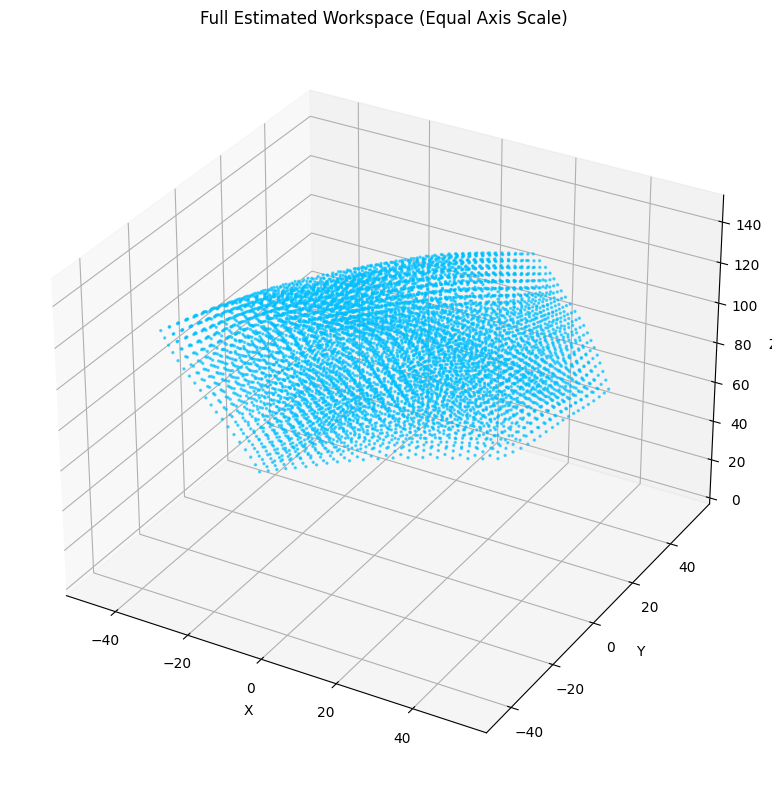

ONNX model saved as nn_model.onnx
Scaler data saved to nn_scalers.json


In [ ]:
# train and save the pure nn model

import util
import torch
import json

model, scaler_x, scaler_y = util.train_and_visualize_workspace("merged_cleaned.csv")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Save model as ONNX instead of TorchScript ===
model_input = torch.tensor(
    scaler_x.transform([[100.0, 100.0, 100.0]]), dtype=torch.float32
).to(device)

onnx_path = "nn_model.onnx"
torch.onnx.export(
    model,
    model_input,  # dummy input
    onnx_path,
    input_names=["actuators"],
    output_names=["residual"],
    dynamic_axes={"actuators": {0: "batch"}, "residual": {0: "batch"}},
    opset_version=11,
)
print(f"ONNX model saved as {onnx_path}")


# === Save scaler parameters to JSON (unchanged) ===
scaler_data = {
    "x_mean": scaler_x.mean_.tolist(),
    "x_scale": scaler_x.scale_.tolist(),
    "y_mean": scaler_y.mean_.tolist(),
    "y_scale": scaler_y.scale_.tolist(),
}

with open("nn_scalers.json", "w") as f:
    json.dump(scaler_data, f)
print("Scaler data saved to nn_scalers.json")

In [2]:
import torch
import json
import numpy as np

import onnx  # optional, for validation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Save model as ONNX instead of TorchScript ===
model_input = torch.tensor(
    scaler_x.transform([[100.0, 100.0, 100.0]]), dtype=torch.float32
).to(device)

onnx_path = "residual_model.onnx"
torch.onnx.export(
    model,
    model_input,  # dummy input
    onnx_path,
    input_names=["actuators"],
    output_names=["residual"],
    dynamic_axes={"actuators": {0: "batch"}, "residual": {0: "batch"}},
    opset_version=11,
)
print(f"ONNX model saved as {onnx_path}")


# === Save scaler parameters to JSON (unchanged) ===
scaler_data = {
    "x_mean": scaler_x.mean_.tolist(),
    "x_scale": scaler_x.scale_.tolist(),
    "y_mean": scaler_y.mean_.tolist(),
    "y_scale": scaler_y.scale_.tolist(),
}

with open("scalers.json", "w") as f:
    json.dump(scaler_data, f)
print("Scaler data saved to scalers.json")


ONNX model saved as residual_model.onnx
Scaler data saved to scalers.json


In [1]:
import onnx

onnx_path = "residual_model.onnx"

# === Optional: Validate ONNX model ===
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
print("ONNX model structure is valid")

model = onnx.load("residual_model.onnx")
print("Outputs:")
for output in model.graph.output:
    print(output.name)

import onnxruntime as ort
import numpy as np

sess = ort.InferenceSession("residual_model.onnx")
input_name = sess.get_inputs()[0].name

# match your scaled input here
x = np.array([[53.066658, 53.066658, 52.899994]], dtype=np.float32)
x_scaled = (x - np.array([81.7983, 83.1406, 82.1538])) / np.array(
    [18.6717, 19.4162, 18.5078]
)

out = sess.run(None, {input_name: x_scaled.astype(np.float32)})
print("ONNX Output:", out)


ONNX model structure is valid
Outputs:
residual


ImportError: DLL load failed while importing onnxruntime_pybind11_state: 动态链接库(DLL)初始化例程失败。

In [ ]:
import torch
import json
import numpy as np
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== 2. Load scalers ====
with open("scalers.json", "r") as f:
    scaler_data = json.load(f)

x_mean = np.array(scaler_data["x_mean"])
x_scale = np.array(scaler_data["x_scale"])

y_mean = np.array(scaler_data["y_mean"])
y_scale = np.array(scaler_data["y_scale"])

# ==== 3. Prepare input that caused NaN in Rust ====
x_raw = np.array([[90.99999, 91.09999, 90.99999]], dtype=np.float32)
x_scaled = (x_raw - x_mean) / x_scale

print("Scaled input:", x_scaled)

# ==== 4. Run model forward pass ====
model.eval()
with torch.no_grad():
    x_tensor = torch.tensor(x_scaled, dtype=torch.float32).to(device)
    output = model(x_tensor)
    output_np = output.cpu().numpy()

print("Model output:", output_np)
print("Model scaled output:", (output_np + y_mean) * y_scale)

# ==== 5. Check if it contains NaN ====
if np.isnan(output_np).any():
    print("❌ Model output contains NaN!")
else:
    print("✅ Model output is valid.")


Scaled input: [[0.492813   0.40993882 0.47796995]]
Model output: [[-0.35798767 -0.09628411  0.49879035]]
Model scaled output: [[  4.4599048    2.11819933 -31.02057006]]
✅ Model output is valid.
